In [1]:
#StyleGAN Implementation in PyTorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import gc
from torch.cuda.amp import autocast, GradScaler

class FaceDataset(Dataset):
    def __init__(self, root_dir, image_size=128):  # Reduced default image size
        self.root_dir = root_dir
        self.image_size = image_size
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        self.image_files = [
            os.path.join(root_dir, f) for f in os.listdir(root_dir) 
            if f.endswith('.jpg')
        ]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        return self.transform(image)

class MappingNetwork(nn.Module):
    def __init__(self, latent_dim=512, n_layers=4):  # Reduced number of layers
        super().__init__()
        layers = []
        for i in range(n_layers):
            layers.extend([
                nn.Linear(latent_dim, latent_dim),
                nn.LeakyReLU(0.2),
                nn.BatchNorm1d(latent_dim)
            ])
        self.mapping = nn.Sequential(*layers)
    
    def forward(self, z):
        return self.mapping(z)

class AdaIN(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
    
    def forward(self, x, style):
        batch = x.size(0)
        mean = x.mean(dim=[2, 3], keepdim=True)
        var = x.var(dim=[2, 3], keepdim=True) + 1e-8
        x = (x - mean) / torch.sqrt(var)
        
        style = style.view(batch, 2, self.channels, 1, 1)
        return x * style[:, 0] + style[:, 1]

class GeneratorBlock(nn.Module):
    def __init__(self, in_channels, out_channels, w_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.adain1 = AdaIN(out_channels)
        self.adain2 = AdaIN(out_channels)
        self.style1 = nn.Linear(w_dim, out_channels * 2)
        self.style2 = nn.Linear(w_dim, out_channels * 2)
        
    def forward(self, x, w):
        s1 = self.style1(w)
        s2 = self.style2(w)
        
        x = self.conv1(x)
        x = self.adain1(x, s1)
        x = F.leaky_relu(x, 0.2)
        
        x = self.conv2(x)
        x = self.adain2(x, s2)
        x = F.leaky_relu(x, 0.2)
        
        return x

class StyleGANGenerator(nn.Module):
    def __init__(self, latent_dim=512, n_layers=5):  # Reduced number of layers
        super().__init__()
        self.mapping = MappingNetwork(latent_dim)
        self.constant = nn.Parameter(torch.randn(1, 512, 4, 4))
        
        # Reduced number of channels
        channels = [512, 256, 128, 64, 32, 16]
        
        self.blocks = nn.ModuleList()
        for i in range(n_layers):
            in_ch = channels[i]
            out_ch = channels[i + 1] if i < len(channels) - 1 else channels[-1]
            self.blocks.append(GeneratorBlock(in_ch, out_ch, latent_dim))
            
        self.to_rgb = nn.Conv2d(16, 3, 1)
        
    def forward(self, z):
        batch_size = z.size(0)
        w = self.mapping(z)
        x = self.constant.repeat(batch_size, 1, 1, 1)
        
        for block in self.blocks:
            x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
            x = block(x, w)
        
        return torch.tanh(self.to_rgb(x))

class StyleGANDiscriminator(nn.Module):
    def __init__(self, n_layers=5):  # Reduced number of layers
        super().__init__()
        # Reduced number of channels
        channels = [16, 32, 64, 128, 256, 512]
        
        self.from_rgb = nn.Conv2d(3, channels[0], 1)
        
        self.blocks = nn.ModuleList()
        for i in range(n_layers):
            self.blocks.append(nn.Sequential(
                nn.Conv2d(channels[i], channels[i+1], 3, padding=1),
                nn.LeakyReLU(0.2),
                nn.AvgPool2d(2)
            ))
            
        self.final = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels[-1] * 4 * 4, 1)
        )
        
    def forward(self, x):
        x = F.leaky_relu(self.from_rgb(x), 0.2)
        
        for block in self.blocks:
            x = block(x)
            
        return self.final(x)

def train_stylegan(train_dir, test_dir, num_epochs=100, batch_size=8):  # Reduced batch size
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Initialize dataset with smaller image size
    train_dataset = FaceDataset(train_dir, image_size=128)
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=2,  # Reduced number of workers
        pin_memory=True
    )
    
    generator = StyleGANGenerator().to(device)
    discriminator = StyleGANDiscriminator().to(device)
    
    # Use mixed precision training
    scaler = GradScaler()
    
    # Use different learning rates for generator and discriminator
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001, betas=(0.0, 0.99))
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.0, 0.99))
    
    # Learning rate schedulers
    g_scheduler = torch.optim.lr_scheduler.ExponentialLR(g_optimizer, gamma=0.99)
    d_scheduler = torch.optim.lr_scheduler.ExponentialLR(d_optimizer, gamma=0.99)
    
    for epoch in range(num_epochs):
        for batch_idx, real_images in enumerate(train_loader):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)
            
            # Clear cache periodically
            if batch_idx % 10 == 0:
                torch.cuda.empty_cache()
            
            # Train Discriminator
            with autocast():
                d_optimizer.zero_grad()
                
                label_real = torch.ones(batch_size, 1).to(device)
                label_fake = torch.zeros(batch_size, 1).to(device)
                
                d_output_real = discriminator(real_images)
                d_loss_real = F.binary_cross_entropy_with_logits(d_output_real, label_real)
                
                z = torch.randn(batch_size, 512).to(device)
                fake_images = generator(z)
                d_output_fake = discriminator(fake_images.detach())
                d_loss_fake = F.binary_cross_entropy_with_logits(d_output_fake, label_fake)
                
                d_loss = d_loss_real + d_loss_fake
            
            scaler.scale(d_loss).backward()
            scaler.step(d_optimizer)
            
            # Train Generator
            with autocast():
                g_optimizer.zero_grad()
                
                d_output_fake = discriminator(fake_images)
                g_loss = F.binary_cross_entropy_with_logits(d_output_fake, label_real)
            
            scaler.scale(g_loss).backward()
            scaler.step(g_optimizer)
            
            scaler.update()
            
            if batch_idx % 50 == 0:
                print(f'Epoch [{epoch}/{num_epochs}] Batch [{batch_idx}/{len(train_loader)}] '
                      f'd_loss: {d_loss.item():.4f} g_loss: {g_loss.item():.4f}')
                
                # Clear some memory
                del d_loss, g_loss, fake_images, real_images
                torch.cuda.empty_cache()
        
        # Step the schedulers
        g_scheduler.step()
        d_scheduler.step()
        
        # Save checkpoint with memory optimization
        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'g_optimizer_state_dict': g_optimizer.state_dict(),
                'd_optimizer_state_dict': d_optimizer.state_dict(),
            }, f'stylegan_checkpoint_epoch_{epoch+1}.pth')

def explore_latent_space(generator, n_samples=5, save_dir='generated_faces'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    generator.eval()
    
    os.makedirs(save_dir, exist_ok=True)
    
    with torch.no_grad():
        z1 = torch.randn(1, 512).to(device)
        z2 = torch.randn(1, 512).to(device)
        
        for i in range(n_samples):
            # Generate one image at a time to save memory
            alpha = i / (n_samples - 1)
            z = z1 * (1 - alpha) + z2 * alpha
            
            fake_image = generator(z)
            fake_image = (fake_image + 1) / 2
            fake_image = fake_image.cpu().squeeze(0)
            
            transforms.ToPILImage()(fake_image).save(
                os.path.join(save_dir, f'interpolation_{i}.jpg')
            )
            
            # Clear memory
            del fake_image
            torch.cuda.empty_cache()

if __name__ == "__main__":
    # Set memory optimization flags
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    
    train_dir = "/kaggle/input/stylegan/STYLEGAN/train"
    test_dir = "/kaggle/input/stylegan/STYLEGAN/test"
    
    # Train with reduced batch size and image size
    train_stylegan(train_dir, test_dir, batch_size=8)

/tmp/ipykernel_24/3313437055.py:163: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_24/3313437055.py:183: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_24/3313437055.py:203: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [0/100] Batch [0/1249] d_loss: 1.3863 g_loss: 0.6936
Epoch [0/100] Batch [50/1249] d_loss: 0.5117 g_loss: 2.0303
Epoch [0/100] Batch [100/1249] d_loss: 0.1929 g_loss: 3.3530
Epoch [0/100] Batch [150/1249] d_loss: 0.2819 g_loss: 3.0243
Epoch [0/100] Batch [200/1249] d_loss: 0.1065 g_loss: 4.4755
Epoch [0/100] Batch [250/1249] d_loss: 0.7317 g_loss: 4.4058
Epoch [0/100] Batch [300/1249] d_loss: 0.1228 g_loss: 5.2150
Epoch [0/100] Batch [350/1249] d_loss: 0.4841 g_loss: 3.6939
Epoch [0/100] Batch [400/1249] d_loss: 0.4132 g_loss: 3.2246
Epoch [0/100] Batch [450/1249] d_loss: 0.2206 g_loss: 4.4396
Epoch [0/100] Batch [500/1249] d_loss: 0.3015 g_loss: 5.8677
Epoch [0/100] Batch [550/1249] d_loss: 0.6239 g_loss: 5.5074
Epoch [0/100] Batch [600/1249] d_loss: 0.3324 g_loss: 4.2481
Epoch [0/100] Batch [650/1249] d_loss: 0.3011 g_loss: 7.2241
Epoch [0/100] Batch [700/1249] d_loss: 0.1154 g_loss: 6.9166
Epoch [0/100] Batch [750/1249] d_loss: 0.0155 g_loss: 7.3957
Epoch [0/100] Batch [800/12

In [2]:
#Generate Sample Images from StyleGAN

import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torchvision import transforms
import os

def generate_samples(checkpoint_path, num_samples=16, output_dir='generated_samples'):
    """
    Generate and save sample images from a trained StyleGAN model
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load the trained generator
    generator = StyleGANGenerator().to(device)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    generator.eval()
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    with torch.no_grad():
        # Generate random latent vectors
        z = torch.randn(num_samples, 512).to(device)
        
        # Generate images
        fake_images = generator(z)
        
        # Normalize images from [-1, 1] to [0, 1]
        fake_images = (fake_images + 1) / 2.0
        
        # Save individual images
        for i, image in enumerate(fake_images):
            img_path = os.path.join(output_dir, f'sample_{i+1}.png')
            vutils.save_image(image, img_path, normalize=False)
        
        # Create a grid of images
        grid = vutils.make_grid(fake_images, nrow=4, padding=2, normalize=False)
        grid_path = os.path.join(output_dir, 'samples_grid.png')
        vutils.save_image(grid, grid_path)
        
        # Display the grid
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.title('Generated Samples')
        plt.imshow(grid.cpu().permute(1, 2, 0))
        plt.savefig(os.path.join(output_dir, 'samples_6.png'))
        plt.close()

def create_style_mixing(checkpoint_path, num_samples=4, output_dir='style_mixing'):
    """
    Generate images with mixed styles from different latent vectors
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load the trained generator
    generator = StyleGANGenerator().to(device)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    generator.eval()
    
    os.makedirs(output_dir, exist_ok=True)
    
    with torch.no_grad():
        # Generate two sets of latent vectors
        z1 = torch.randn(num_samples, 512).to(device)
        z2 = torch.randn(num_samples, 512).to(device)
        
        # Get their W representations
        w1 = generator.mapping(z1)
        w2 = generator.mapping(z2)
        
        # Generate original images
        images1 = generator(z1)
        images2 = generator(z2)
        
        # Create mixed styles
        w_mixed = w1.clone()
        w_mixed[:, len(generator.blocks)//2:] = w2[:, len(generator.blocks)//2:]
        
        # Generate mixed images
        images_mixed = generator(w_mixed)
        
        # Normalize images
        images1 = (images1 + 1) / 2
        images2 = (images2 + 1) / 2
        images_mixed = (images_mixed + 1) / 2
        
        # Create comparison grid
        all_images = torch.cat([images1, images2, images_mixed], dim=0)
        grid = vutils.make_grid(all_images, nrow=num_samples, padding=2, normalize=False)
        
        # Save grid
        vutils.save_image(grid, os.path.join(output_dir, 'style_mixing_grid.png'))
        
        # Display grid
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.title('Style Mixing Results\nTop: Source 1 | Middle: Source 2 | Bottom: Mixed')
        plt.imshow(grid.cpu().permute(1, 2, 0))
        plt.savefig(os.path.join(output_dir, 'style_mixing_display.png'))
        plt.close()

if __name__ == "__main__":
    checkpoint_path = "stylegan_checkpoint_epoch_100.pth"  # Adjust path as needed
    
    # Generate regular samples
    generate_samples(checkpoint_path, num_samples=16)
    
    # Generate style mixing examples
    create_style_mixing(checkpoint_path, num_samples=4)

/tmp/ipykernel_24/1112778678.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
/tmp/ipykernel_24/1112778678.

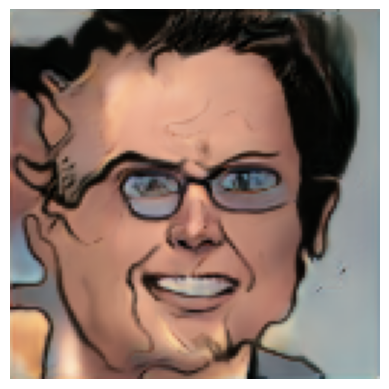

In [3]:
import os

# Folder path containing the saved images
folder_path = '/kaggle/working/generated_samples/'

# Get the list of images
images = os.listdir(folder_path)

# Display the first image
image_path = os.path.join(folder_path, images[2])
img = Image.open(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()


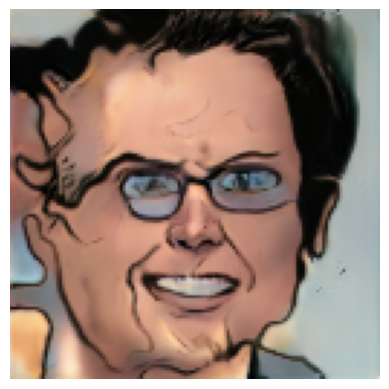

In [4]:
import os

# Folder path containing the saved images
folder_path = '/kaggle/working/generated_samples/'

# Get the list of images
images = os.listdir(folder_path)

# Display the first image
image_path = os.path.join(folder_path, images[10])
img = Image.open(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()


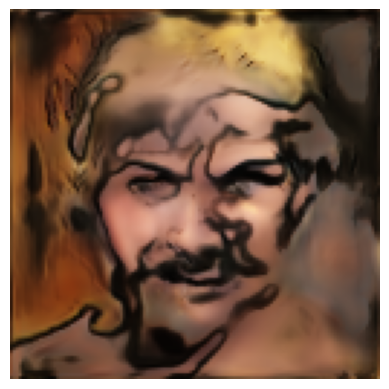

In [5]:
import os

# Folder path containing the saved images
folder_path = '/kaggle/working/generated_samples/'

# Get the list of images
images = os.listdir(folder_path)

# Display the first image
image_path = os.path.join(folder_path, images[5])
img = Image.open(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()


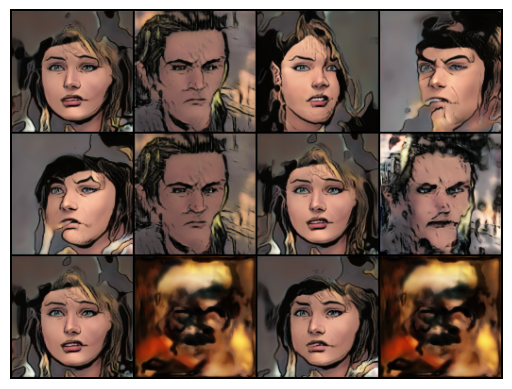

In [6]:
import os

# Folder path containing the saved images
folder_path = '/kaggle/working/style_mixing/'

# Get the list of images
images = os.listdir(folder_path)

# Display the first image
image_path = os.path.join(folder_path, images[0])
img = Image.open(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()


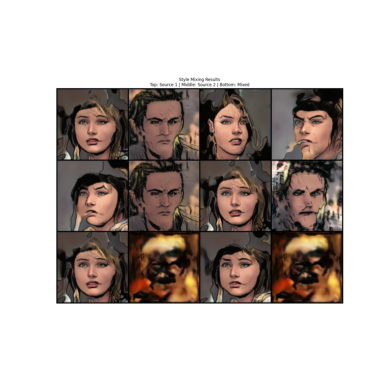

In [7]:
import os

# Folder path containing the saved images
folder_path = '/kaggle/working/style_mixing/'

# Get the list of images
images = os.listdir(folder_path)

# Display the first image
image_path = os.path.join(folder_path, images[1])
img = Image.open(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()
